In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor 
from scipy.stats import skew, kurtosis
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
from lightgbm import plot_importance
from scipy.stats import entropy
from scipy.signal import welch
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler

C:\Users\kaan9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train/Test Data Prep

In [2]:
def get_freq_features(x,col):
    
    fft_vals = np.abs(fft(x))
    fft_freqs = np.fft.fftfreq(len(fft_vals))
    dominant_freq = fft_freqs[np.argmax(fft_vals)]
    fft_mean = np.mean(fft_vals)
    fft_std = np.std(fft_vals)
    fft_max = np.max(fft_vals)
    freqs, psd = welch(x)
    psd_mean = np.mean(psd)
    psd_max = np.max(psd)
    psd_norm = psd / np.sum(psd)
    spectral_entropy = entropy(psd_norm)
    spectral_centroid = np.sum(freqs * psd) / np.sum(psd)
    spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * psd) / np.sum(psd))
    spectral_rolloff = freqs[np.where(np.cumsum(psd) >= 0.85 * np.sum(psd))[0][0]]

    feature_dict = {}
    feature_dict[col+'_dominant_freq'] = dominant_freq
    feature_dict[col+'_fft_mean'] = fft_mean
    feature_dict[col+'_fft_std'] = fft_std
    feature_dict[col+'_fft_max'] = fft_max
    feature_dict[col+'_psd_mean'] = psd_mean
    feature_dict[col+'_psd_max'] = psd_max
    feature_dict[col+'_spectral_entropy'] = spectral_entropy
    feature_dict[col+'_spectral_centroid'] = spectral_centroid
    feature_dict[col+'_spectral_bandwidth'] = spectral_bandwidth
    feature_dict[col+'_spectral_rolloff'] = spectral_rolloff

    return feature_dict

In [3]:
def data_prep(path):
    
    data_pd = pd.read_csv(path)

    data_pd['magnitude_acc'] = np.sqrt(data_pd['acc_x']**2+data_pd['acc_y']**2+data_pd['acc_z']**2)
    data_pd['magnitude_gy'] = np.sqrt(data_pd['gy_x']**2+data_pd['gy_y']**2+data_pd['gy_z']**2)
    data_pd['magnitude_mag'] = np.sqrt(data_pd['mag_x']**2+data_pd['mag_y']**2+data_pd['mag_z']**2)

    data_pd['genre_coded'] = data_pd['genre'].astype('category').cat.codes

    sensor_cols = ['acc_x','acc_y','acc_z','magnitude_acc','gy_x','gy_y','gy_z','magnitude_gy','mag_x','mag_y','mag_z','magnitude_mag']

    sensor_cols_raw = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z','mag_x','mag_y','mag_z']

    scaled_pd = []
    for id in data_pd['subject_id'].unique():
        filtered_pd = data_pd[data_pd['subject_id']==id]
        for col in sensor_cols:
            scaler = StandardScaler()
            col_scaled = scaler.fit_transform(filtered_pd[col].values.reshape(-1,1))
            filtered_pd[col] = col_scaled.reshape(-1)
        scaled_pd.append(filtered_pd)

    scaled_pd = pd.concat(scaled_pd)

    data_list = scaled_pd.groupby(['subject_id','label','genre_coded'])[['acc_x','acc_y','acc_z','magnitude_acc','gy_x','gy_y','gy_z','magnitude_gy','mag_x','mag_y','mag_z','magnitude_mag']].agg(list).reset_index()

    tmp = data_pd.groupby(['subject_id','label','genre_coded'])[['acc_x','acc_y','acc_z','magnitude_acc','gy_x','gy_y','gy_z','magnitude_gy','mag_x','mag_y','mag_z','magnitude_mag']].agg(list).reset_index()

    freq_features = []

    for col in sensor_cols_raw:
        data_list[col+'_diff1'] = data_list[col].apply(lambda x: np.roll(x,-1)[:-1] - np.array(x)[:-1])
        data_list[col+'_diff2'] = data_list[col+'_diff1'].apply(lambda x: np.roll(x,-1)[:-1] - np.array(x)[:-1])
        sensor_cols += [col+'_diff1',col+'_diff2']
        freq_features_pd = pd.DataFrame(data_list[col].apply(lambda x: get_freq_features(x,col)).tolist())
        freq_features.append(freq_features_pd)

    data_list = pd.concat([data_list]+freq_features,axis=1)

    for col in sensor_cols:
        data_list[col+'_mean'] = data_list[col].apply(lambda x: np.mean(x))
        data_list[col+'_std'] = data_list[col].apply(lambda x: np.std(x))
        data_list[col+'_min'] = data_list[col].apply(lambda x: np.min(x))
        data_list[col+'_max'] = data_list[col].apply(lambda x: np.max(x))
        data_list[col+'_range'] = data_list[col].apply(lambda x: np.max(x)-np.min(x))
        data_list[col+'_skew'] = data_list[col].apply(lambda x: skew(x))
        data_list[col+'_kurtosis'] = data_list[col].apply(lambda x: kurtosis(x))

    return data_list.drop(sensor_cols,axis=1)

In [4]:
train_data = data_prep("data/data_trimmed.csv")
test_data = data_prep("data/data_trimmed_2.csv")

C:\Users\kaan9\AppData\Local\Temp\ipykernel_15980\1905533733.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pd[col] = col_scaled.reshape(-1)
C:\Users\kaan9\AppData\Local\Temp\ipykernel_15980\1905533733.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pd[col] = col_scaled.reshape(-1)
C:\Users\kaan9\AppData\Local\Temp\ipykernel_15980\1905533733.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

### LighGBM Model

In [14]:
lgb_params = {'n_estimators': 60,
 'num_leaves': 50,
 'min_data_in_leaf': 5,
 'max_depth': 11,
 'learning_rate': 0.22,
 'lambda_l1': 3.0,
 'lambda_l2': 0.0,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.6000000000000001,
 'bagging_freq': 6,
 'min_gain_to_split': 0.05}

selected_cols_lgb = ['acc_x_dominant_freq','acc_x_fft_max','acc_x_psd_mean','acc_x_spectral_bandwidth','acc_x_spectral_rolloff','acc_y_dominant_freq','acc_y_fft_mean','acc_y_fft_std','acc_y_fft_max','acc_y_spectral_entropy','acc_y_spectral_bandwidth','acc_y_spectral_rolloff','acc_z_fft_std','acc_z_psd_max','acc_z_spectral_entropy','acc_z_spectral_centroid','acc_z_spectral_bandwidth','gy_x_fft_std','gy_x_fft_max','gy_x_psd_max','gy_x_spectral_entropy','gy_x_spectral_centroid','gy_x_spectral_rolloff','gy_y_dominant_freq','gy_y_spectral_centroid','gy_z_dominant_freq','gy_z_fft_mean','gy_z_fft_max','gy_z_psd_max','gy_z_spectral_bandwidth','gy_z_spectral_rolloff','mag_x_fft_std','mag_x_fft_max','mag_x_psd_max','mag_x_spectral_bandwidth','mag_x_spectral_rolloff','mag_y_dominant_freq','mag_y_fft_max','mag_y_psd_max','mag_y_spectral_entropy','mag_y_spectral_centroid','mag_y_spectral_rolloff','mag_z_fft_mean','mag_z_fft_max','mag_z_psd_max','mag_z_spectral_bandwidth','acc_x_std','acc_x_min','acc_x_max','acc_x_range','acc_x_skew','acc_x_kurtosis','acc_y_skew','acc_y_kurtosis','acc_z_min','acc_z_skew','acc_z_kurtosis','magnitude_acc_std','magnitude_acc_min','magnitude_acc_range','gy_x_mean','gy_x_std','gy_x_skew','gy_x_kurtosis','gy_y_mean','gy_y_std','gy_y_kurtosis','gy_z_std','gy_z_max','magnitude_gy_mean','magnitude_gy_std','magnitude_gy_kurtosis','mag_x_max','mag_x_skew','mag_y_std','mag_y_range','mag_z_range','mag_z_skew','magnitude_mag_min','magnitude_mag_range','acc_x_diff1_max','acc_x_diff1_range','acc_x_diff1_skew','acc_x_diff1_kurtosis','acc_x_diff2_min','acc_x_diff2_kurtosis','acc_y_diff1_mean','acc_y_diff1_max','acc_y_diff1_skew','acc_y_diff2_min','acc_y_diff2_max','acc_y_diff2_range','acc_y_diff2_skew','acc_y_diff2_kurtosis','acc_z_diff1_mean','acc_z_diff1_std','acc_z_diff1_min','acc_z_diff1_range','acc_z_diff2_mean','acc_z_diff2_std','acc_z_diff2_skew','gy_x_diff1_mean','gy_x_diff1_std','gy_x_diff1_max','gy_x_diff1_kurtosis','gy_x_diff2_std','gy_x_diff2_min','gy_x_diff2_skew','gy_y_diff1_std','gy_y_diff1_min','gy_y_diff1_max','gy_y_diff1_kurtosis','gy_y_diff2_mean','gy_y_diff2_std','gy_y_diff2_range','gy_y_diff2_skew','gy_y_diff2_kurtosis','gy_z_diff1_min','gy_z_diff2_min','mag_x_diff1_mean','mag_x_diff1_std','mag_x_diff1_max','mag_x_diff1_range','mag_x_diff1_skew','mag_x_diff2_mean','mag_x_diff2_min','mag_y_diff2_mean','mag_y_diff2_min','mag_y_diff2_max','mag_z_diff1_std','mag_z_diff1_min','mag_z_diff1_max','mag_z_diff2_mean','mag_z_diff2_std','mag_z_diff2_max']

X_train = train_data[selected_cols_lgb]
y_train = train_data['genre_coded']

model_lgb = LGBMClassifier(objective='multiclass',num_class=4,**lgb_params,verbose=-1)
model_lgb.fit(X_train,y_train)

X_test = test_data[selected_cols_lgb]
y_test = test_data['genre_coded']

preds = model_lgb.predict(X_test)

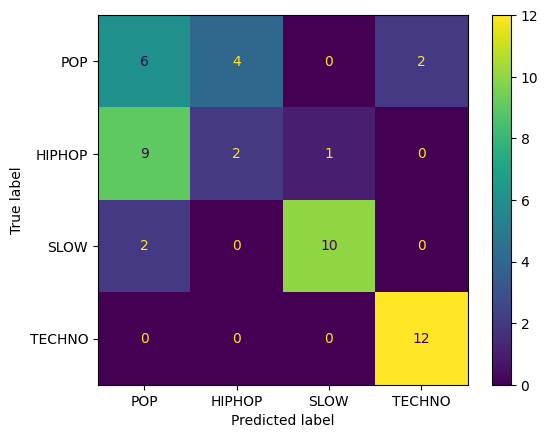

Test Accuracy: 0.625
Test F1: 0.6071643665346814


In [15]:
conf_mat = confusion_matrix(y_test,preds)



disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=['POP','HIPHOP','SLOW','TECHNO'])
disp.plot()
plt.show()

print(f"Test Accuracy: {accuracy_score(y_test,preds)}")
print(f"Test F1: {f1_score(y_test,preds,average='weighted')}")

### Random Forest Model

In [16]:
rf_params = {'n_estimators': 200,
 'max_depth': 27,
 'min_samples_split': 2,
 'min_samples_leaf': 9,
 'max_features': 0.5,
 'bootstrap': True}

selected_cols_rf = ['acc_x_dominant_freq','acc_x_fft_max','acc_x_spectral_entropy','acc_x_spectral_rolloff','acc_y_fft_mean','acc_y_psd_max','acc_y_spectral_centroid','acc_y_spectral_bandwidth','acc_z_fft_max','acc_z_spectral_bandwidth','acc_z_spectral_rolloff','gy_x_dominant_freq','gy_x_fft_max','gy_x_psd_mean','gy_x_spectral_entropy','gy_x_spectral_centroid','gy_y_dominant_freq','gy_y_fft_mean','gy_y_fft_std','gy_y_fft_max','gy_y_psd_mean','gy_y_spectral_rolloff','gy_z_spectral_centroid','mag_x_dominant_freq','mag_x_fft_mean','mag_x_fft_std','mag_x_fft_max','mag_x_psd_mean','mag_x_spectral_entropy','mag_y_dominant_freq','mag_y_fft_mean','mag_y_psd_mean','mag_y_spectral_entropy','mag_y_spectral_rolloff','mag_z_dominant_freq','mag_z_fft_mean','mag_z_fft_std','mag_z_fft_max','mag_z_psd_mean','mag_z_psd_max','mag_z_spectral_entropy','mag_z_spectral_centroid','acc_x_range','acc_y_min','acc_y_max','acc_y_skew','acc_z_min','acc_z_range','magnitude_acc_std','magnitude_acc_kurtosis','gy_x_std','gy_x_min','gy_x_max','gy_x_range','gy_x_skew','gy_x_kurtosis','gy_y_min','gy_y_max','gy_y_range','gy_z_mean','gy_z_std','gy_z_min','gy_z_skew','gy_z_kurtosis','magnitude_gy_mean','magnitude_gy_min','magnitude_gy_max','mag_x_min','mag_x_range','mag_x_kurtosis','mag_y_mean','mag_y_std','mag_z_mean','mag_z_std','mag_z_min','mag_z_max','mag_z_kurtosis','magnitude_mag_min','magnitude_mag_range','magnitude_mag_kurtosis','acc_x_diff1_std','acc_x_diff1_min','acc_x_diff1_max','acc_x_diff1_skew','acc_x_diff1_kurtosis','acc_y_diff1_mean','acc_y_diff1_std','acc_y_diff1_min','acc_y_diff1_range','acc_y_diff1_skew','acc_y_diff2_min','acc_y_diff2_max','acc_y_diff2_range','acc_y_diff2_skew','acc_z_diff1_mean','acc_z_diff1_max','acc_z_diff1_skew','acc_z_diff1_kurtosis','acc_z_diff2_range','acc_z_diff2_skew','gy_x_diff1_range','gy_x_diff2_min','gy_x_diff2_max','gy_x_diff2_range','gy_y_diff1_mean','gy_y_diff1_std','gy_y_diff1_min','gy_y_diff1_kurtosis','gy_y_diff2_min','gy_y_diff2_max','gy_y_diff2_range','gy_y_diff2_skew','gy_z_diff1_std','gy_z_diff1_range','gy_z_diff1_skew','gy_z_diff2_mean','gy_z_diff2_std','gy_z_diff2_min','gy_z_diff2_range','gy_z_diff2_skew','gy_z_diff2_kurtosis','mag_x_diff1_std','mag_x_diff1_min','mag_x_diff1_max','mag_x_diff1_range','mag_x_diff1_skew','mag_x_diff1_kurtosis','mag_x_diff2_min','mag_x_diff2_skew','mag_y_diff1_mean','mag_y_diff1_std','mag_y_diff1_min','mag_y_diff1_max','mag_y_diff1_skew','mag_y_diff2_mean','mag_y_diff2_std','mag_y_diff2_min','mag_y_diff2_skew','mag_z_diff1_mean','mag_z_diff1_min','mag_z_diff1_max','mag_z_diff1_range','mag_z_diff1_kurtosis','mag_z_diff2_min','mag_z_diff2_range','mag_z_diff2_kurtosis']

X_train = train_data[selected_cols_rf]
y_train = train_data['genre_coded']

model_rf = RandomForestClassifier(**rf_params, n_jobs=-1)
model_rf.fit(X_train,y_train)

X_test = test_data[selected_cols_rf]
y_test = test_data['genre_coded']

preds = model_rf.predict(X_test)

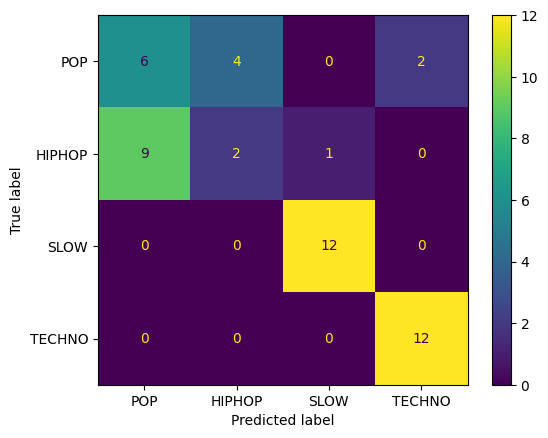

Test Accuracy: 0.6666666666666666
Test F1: 0.6374358974358975


In [17]:
conf_mat = confusion_matrix(y_test,preds)



disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=['POP','HIPHOP','SLOW','TECHNO'])
disp.plot()
plt.show()

print(f"Test Accuracy: {accuracy_score(y_test,preds)}")
print(f"Test F1: {f1_score(y_test,preds,average='weighted')}")